In [1]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [ ]:
# If you are working in Colab, then consider mounting folder to your drive
from google.colab import drive
drive.mount('/content/drive')

# Direct to your folder.
%cd /content/drive/MyDrive/computer_vision/diffusion_models/

In [2]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel three times
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all three channels
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

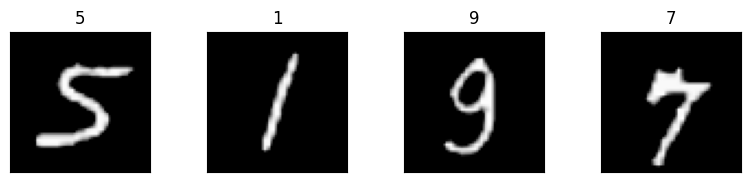

In [3]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

images = np.transpose(images, (0, 2, 3, 1))
images = np.clip(images, 0, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx])
    ax.set_title(str(labels[idx].item()))

plt.show()

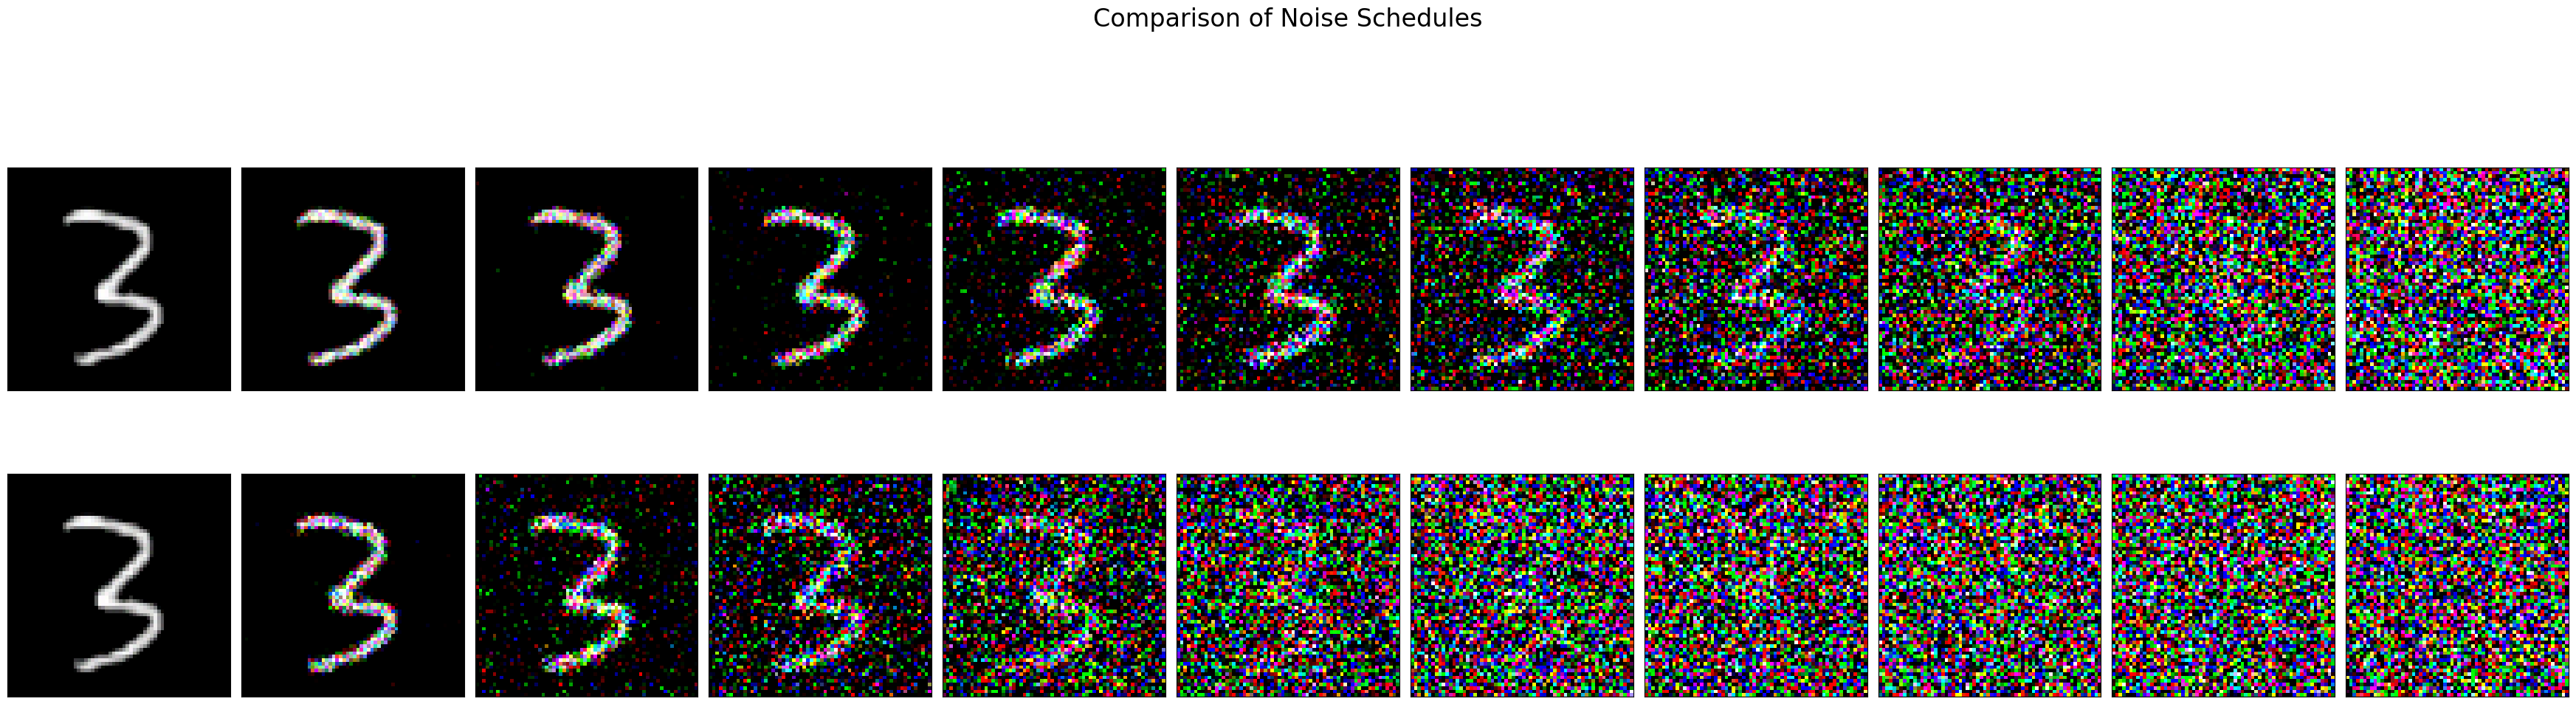

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from ddpm import Diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = next(iter(trainloader))[0].shape[-1]

diffusion_cosine = Diffusion(noise_steps=1000, schedule_type='cosine', img_size=img_size, device=device)
diffusion_linear = Diffusion(noise_steps=1000, schedule_type='linear', img_size=img_size, device=device)

dataiter = iter(trainloader)
images, labels = next(dataiter)

single_image = images[0:1]

timesteps = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999])

fig = plt.figure(figsize=(35, 12))

for idx, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], dtype=torch.long).to(single_image.device)
    
    # Generate noise images with cosine schedule
    noised_image_cosine, _ = diffusion_cosine.noise_images(single_image.clone(), t_tensor)
    noised_image_cosine = noised_image_cosine.squeeze().numpy()
    noised_image_cosine = np.transpose(noised_image_cosine, (1, 2, 0))
    noised_image_cosine = np.clip(noised_image_cosine, 0, 1)
    
    # Generate noise images with linear schedule
    noised_image_linear, _ = diffusion_linear.noise_images(single_image.clone(), t_tensor)
    noised_image_linear = noised_image_linear.squeeze().numpy()
    noised_image_linear = np.transpose(noised_image_linear, (1, 2, 0))
    noised_image_linear = np.clip(noised_image_linear, 0, 1)

    ax1 = fig.add_subplot(2, len(timesteps), idx + 1, xticks=[], yticks=[])
    ax1.imshow(noised_image_cosine)

    ax2 = fig.add_subplot(2, len(timesteps), len(timesteps) + idx + 1, xticks=[], yticks=[])
    ax2.imshow(noised_image_linear)

fig.suptitle('Comparison of Noise Schedules', fontsize=24, y=0.95) 

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
from ddpm import Diffusion, Trainer, UNet
import torch

img_size = next(iter(trainloader))[0].shape[-1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet(in_channels=3, out_channels=3, timestep_dim=256, device=device)
diffusion = Diffusion(noise_steps=1000, schedule_type='cosine', img_size=img_size, device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

trainer = Trainer(model=unet,
                  diffusion=diffusion,
                  optimizer=optimizer,
                  criterion=criterion,
                  trainloader=trainloader,
                  testloader=testloader,
                  save_path='mnist_ddpm.pth',
                  device=device)

In [ ]:
trainer.train_model(epochs=3)

In [7]:
# load the model
trained_unet = UNet(in_channels=3, out_channels=3, timestep_dim=256)
trained_unet.load_state_dict(torch.load('models/mnist_ddpm.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Generating images: 1000it [00:00, 1396.20it/s]


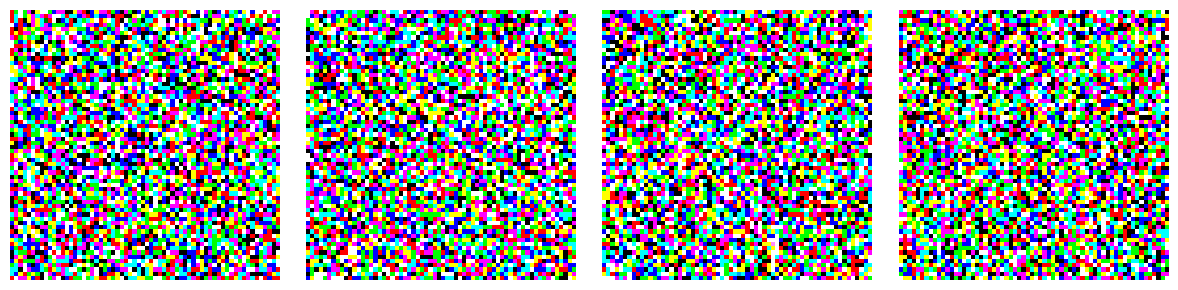

In [10]:
# test the model
generated_images = diffusion.generate_images(trained_unet)
generated_images = np.clip(generated_images.cpu(), 0, 1)

fig, axs = plt.subplots(1, 4, figsize=(4 * 3, 3))
for i, ax in enumerate(axs.flat):
    img = generated_images[i].cpu().permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
trainer = Trainer(model=trained_unet,
                  diffusion=diffusion,
                  optimizer=optimizer,
                  criterion=criterion,
                  trainloader=trainloader,
                  testloader=testloader,
                  save_path='mnist_ddpm.pth',
                  device=device)

trainer.eval_model()